In [31]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [32]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [4]:
print(raw_train_dataset.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}


In [33]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
          1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
          2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
          1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006, 26665,  1007,
         26665,  1011,  2797,  5211,  3813, 18431,  2571,  2177,  1010,  1032,
          2029,  2038,  1037,  5891,  2005,  2437,  2092,  1011, 22313,  1998,
          5681,  1032,  6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,  1997,  1996,
          3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 

In [34]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

In [9]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 267.4 kB/s eta 0:00:00a 0:00:01


In [35]:
import evaluate

accuracy = evaluate.load("accuracy")
print(accuracy.description)
print(accuracy.compute(references=[0, 1, 0, 1], predictions=[1, 0, 0, 1]))


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

{'accuracy': 0.5}


In [36]:
f1_score = evaluate.load("f1")

def compute_metrics(pred):  # 接收包含标签和预测的EvalPrediction
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute F1 score and accuracy
    f1 = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )[
        "f1"
    ]  # 使用所加载的f1_score计算标签和预测的F1分数
    acc = accuracy.compute(references=labels, predictions=preds)[
        "accuracy"
    ]  # 计算准确率

    return {"accuracy": acc, "f1": f1}  # 通过构建字典来返回指标

In [37]:
import torch
from transformers import AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import pprint
pprint.pp(
    """Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference."""
)

('Some weights of DistilBertForSequenceClassification were not initialized '
 'from the model checkpoint at distilbert-base-uncased and are newly '
 "initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', "
 "'pre_classifier.weight']\n"
 'You should probably TRAIN this model on a down-stream task to be able to use '
 'it for predictions and inference.')


In [38]:
from transformers import TrainingArguments

batch_size = 32  # You can change this if you have a big or small GPU
training_args = TrainingArguments(
    "trainer-chapter5",
    push_to_hub=True,  # 是否在每次保存模型时将其推送到Hugging Face Hub。可以通过save_strategy修改保存的频率，默认是几百步。
    num_train_epochs=2, # 执行的epoch总数 to perform；一个epoch是训练数据的一次全传递。    
    evaluation_strategy="epoch", # 何时在验证集上评估模型。默认每500步，但通过指定epoch，在每个 epoch 结束时评估。 
    per_device_train_batch_size=batch_size, # 训练每核的批次大小。如显存耗尽可减小这一数字。 
    per_device_eval_batch_size=batch_size,
)

/root/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
from huggingface_hub import notebook_login 
notebook_login()

In [39]:
from transformers import Trainer

shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.260995,0.910395,0.910242
2,0.301200,0.242787,0.921842,0.921849


TrainOutput(global_step=626, training_loss=0.27579413282985504, metrics={'train_runtime': 108.665, 'train_samples_per_second': 184.052, 'train_steps_per_second': 5.761, 'total_flos': 1875180164398464.0, 'train_loss': 0.27579413282985504, 'epoch': 2.0})

In [41]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AlanHou/trainer-chapter5/commit/6d0cbcb5d814a18247c6ada3513e00371a10ae50', commit_message='End of training', commit_description='', oid='6d0cbcb5d814a18247c6ada3513e00371a10ae50', pr_url=None, pr_revision=None, pr_num=None)

In [42]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="AlanHou/trainer-chapter5")
pipe(
    """The soccer match between Spain and Portugal ended in a terrible result for Portugal."""
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9534329175949097}]

In [25]:
tokenized_datasets["test"].select([0, 1, 2])

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3
})

In [43]:
# Run inference for all samples
trainer_preds = trainer.predict(tokenized_datasets["test"])

# Get the most likely class and the target label
preds = trainer_preds.predictions.argmax(-1)
references = trainer_preds.label_ids
label_names = raw_train_dataset.features["label"].names

In [44]:
# Print results of the first 3 samples
samples = 3
texts = tokenized_datasets["test"]["text"][:samples]

for pred, ref, text in zip(preds[:samples], references[:samples], texts):
    print(f"Predicted {pred}; Actual {ref}; Target name: {label_names[pred]}.")
    print(text)

Predicted 2; Actual 2; Target name: Business.
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted 3; Actual 3; Target name: Sci/Tech.
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Predicted 3; Actual 3; Target name: Sci/Tech.
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.


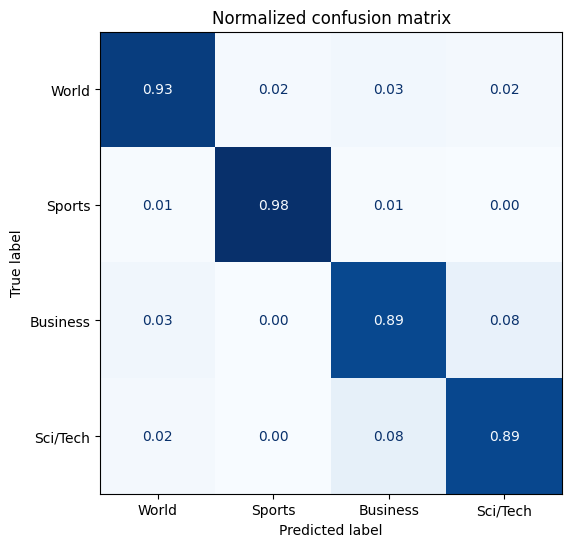

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=preds, normalize="true"
)["confusion_matrix"]

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

plt.title("Normalized confusion matrix")
plt.show()

In [46]:
filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

In [47]:
from transformers import AutoModelForCausalLM

model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = (
    tokenizer.eos_token
)  # Needed as gpt2 does not specify padding token.
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

In [48]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)


tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)


Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

In [33]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1900
    })
})

In [49]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [50]:
samples = [tokenized_datasets["train"][i] for i in range(3)]

for sample in samples:
    print(f"input_ids shape: {len(sample['input_ids'])}")

input_ids shape: 37
input_ids shape: 55
input_ids shape: 51


In [51]:
out = data_collator(samples)
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([3, 55])
attention_mask shape: torch.Size([3, 55])
labels shape: torch.Size([3, 55])


In [52]:
training_args = TrainingArguments(
    "sft_cml",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
)

/root/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [53]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    eval_dataset=tokenized_datasets["test"],
)

In [54]:
trainer.train()

Step,Training Loss,Validation Loss
200,3.662800,3.595686
400,3.317000,3.491657
600,3.103700,3.357159
800,2.139300,3.444315
1000,1.970600,3.406135
1200,1.904400,3.403737


TrainOutput(global_step=1250, training_loss=2.652574377441406, metrics={'train_runtime': 91.9717, 'train_samples_per_second': 108.729, 'train_steps_per_second': 13.591, 'total_flos': 467451445248000.0, 'train_loss': 2.652574377441406, 'epoch': 2.0})

In [55]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AlanHou/sft_cml/commit/09e6393595e279f0eca621ea77ad525209ac8359', commit_message='End of training', commit_description='', oid='09e6393595e279f0eca621ea77ad525209ac8359', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
from transformers import pipeline

pipe = pipeline("text-generation", model="AlanHou/sft_cml", device=device)
pipe.tokenizer.pad_token_id = 50256  # pad_token_id for gpt2
print(pipe("Q1", pad_token_id=tokenizer.eos_token_id)[0]["generated_text"])
print(pipe("Wall", pad_token_id=tokenizer.eos_token_id)[0]["generated_text"])
print(pipe("Google", pad_token_id=tokenizer.eos_token_id)[0]["generated_text"])

Q1 profit rises, says Santander Santander still ahead, but sees no gain ATLANTA (Reuters) - SBC, Europe #39;s seventh-largest bank, is claiming annual profits of up to \$2.35 billion
Wall St. Looks Ahead; Wall Street Awaits Data (Reuters) Reuters - Stocks were set for a slightly\higher open on today as a fall in crude oil prices and reassuring U.S.\economy data about jobs kept Wall
Google posts surge in revenue Shareholders bought up to 30 percent in an unusual auction that began Wednesday in Philadelphia and ended last night in New York with \$2 billion in initial public offerings and 1.5 million shares of debt. The company posted a


In [44]:
!pip install peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [45]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
    fan_in_fan_out=True,
)

model = AutoModelForCausalLM.from_pretrained("gpt2")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


In [47]:
model = AutoModelForCausalLM.from_pretrained("gpt2", torch_dtype=torch.float16)

In [48]:
import numpy as np


def scaling_factor(vector):
    m = np.max(np.abs(vector))
    return 127 / m


array = [1.2, -0.5, -4.3, 1.2, -3.1, 0.8, 2.4, 5.4]
alpha = scaling_factor(array)
quantized_array = np.round(alpha * np.array(array)).astype(np.int8)
dequantized_array = quantized_array / alpha

print(f"Scaling factor: {alpha}")
print(f"Quantized array: {quantized_array}")
print(f"Dequantized array: {dequantized_array}")
print(f"Difference: {array - dequantized_array}")

Scaling factor: 23.518518518518515
Quantized array: [  28  -12 -101   28  -73   19   56  127]
Dequantized array: [ 1.19055118 -0.51023622 -4.29448819  1.19055118 -3.10393701  0.80787402
  2.38110236  5.4       ]
Difference: [ 0.00944882  0.01023622 -0.00551181  0.00944882  0.00393701 -0.00787402
  0.01889764  0.        ]


In [2]:
!pip install bitsandbytes

from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained("gpt2", quantization_config=quantization_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [1]:
from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    quantization_config=quantization_config,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.3 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from peft import LoraConfig
from transformers import TrainingArguments

dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

Repo card metadata block was not found. Setting CardData to empty.


In [8]:

training_args = TrainingArguments(
    "sft_cml2",
    push_to_hub=False,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    gradient_checkpointing=True,
)

/root/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset.select(range(300)),
    dataset_text_field="text",
    peft_config=peft_config,
    max_seq_length=512,
)

/root/miniconda3/envs/llm/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/root/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/root/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/root/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is d

In [10]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/root/miniconda3/envs/llm/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


TrainOutput(global_step=76, training_loss=1.115439264397872, metrics={'train_runtime': 349.1811, 'train_samples_per_second': 1.718, 'train_steps_per_second': 0.218, 'total_flos': 1.3004345114492928e+16, 'train_loss': 1.115439264397872, 'epoch': 2.0})